# Multi-Agent Applications: Building Investment Agent Teams with LangGraph

In this notebook, we'll explore **multi-agent systems** - applications where multiple specialized agents collaborate to solve complex tasks. We'll build on our LangGraph foundation from Module 4 and create agent teams for our Stone Ridge Investment Advisory Team.

**Learning Objectives:**
- Understand when and why to use multi-agent systems
- Master the Supervisor pattern for orchestrating investment agent teams
- Implement Agent Handoffs for dynamic task routing across investment domains
- Use Tavily Search for web research on current market data
- Apply context engineering principles to optimize agent performance with financial information
- Visualize and debug multi-agent systems with LangSmith

## Table of Contents:

- **Breakout Room #1:** Multi-Agent Fundamentals & Supervisor Pattern
  - Task 1: Dependencies & Environment Setup
  - Task 2: Understanding Multi-Agent Systems
  - Task 3: Building a Supervisor Agent Pattern
  - Task 4: Adding Tavily Search for Web Research
  - Question #1 & Question #2
  - Activity #1: Add a Custom Investment Specialist Agent

- **Breakout Room #2:** Handoffs & Context Engineering
  - Task 5: Agent Handoffs Pattern
  - Task 6: Building an Investment Agent Team
  - Task 7: Context Engineering & Optimization
  - Task 8: Visualizing and Debugging with LangSmith
  - Question #3 & Question #4
  - Activity #2: Implement Hierarchical Teams

---
# 🤝 Breakout Room #1
## Multi-Agent Fundamentals & Supervisor Pattern

## Task 1: Dependencies & Environment Setup

Before we begin, make sure you have:

1. **API Keys** for:
   - Anthropic (for Claude Sonnet 4.5 supervisor and Claude Haiku specialist agents)
   - Tavily (free tier at [tavily.com](https://www.tavily.com/))
   - LangSmith (optional, for tracing)

2. **Dependencies installed** via `uv sync`

**Models Used:**
- **Claude Sonnet 4.5**: Supervisor/orchestrator agents (better reasoning for routing decisions)
- **Claude Haiku**: Specialist agents (cost-effective for domain-specific tasks)

**Documentation:**
- [Tavily Search API](https://docs.tavily.com/)
- [Anthropic API Documentation](https://docs.anthropic.com/)
- [LangChain-Anthropic Integration](https://python.langchain.com/docs/integrations/chat/anthropic/)

In [80]:
# Core imports
import os
import getpass
import json
from uuid import uuid4
from typing import Annotated, TypedDict, Literal, Sequence
import operator

import nest_asyncio
nest_asyncio.apply()  # Required for async operations in Jupyter

# Zscaler SSL setup for corporate network
import certifi

zscaler_cert = "/Users/ari.packer/repos/sidekick/zscaler.pem"
combined_cert = "/tmp/combined_certs.pem"

with open(combined_cert, "w") as outfile:
    with open(certifi.where(), "r") as certifi_file:
        outfile.write(certifi_file.read())
    with open(zscaler_cert, "r") as zscaler_file:
        outfile.write(zscaler_file.read())

os.environ['REQUESTS_CA_BUNDLE'] = combined_cert
os.environ['SSL_CERT_FILE'] = combined_cert
os.environ['CURL_CA_BUNDLE'] = combined_cert

print("Zscaler SSL certificates configured")

Zscaler SSL certificates configured


In [81]:
# Set Anthropic API Key
os.environ["ANTHROPIC_API_KEY"] = os.environ.get("ANTHROPIC_API_KEY", "")

In [82]:
# Tavily API Key for web search
os.environ["TAVILY_API_KEY"] = os.environ.get("TAVILY_API_KEY", "")

In [83]:
# Optional: LangSmith for tracing
#os.environ["LANGCHAIN_TRACING_V2"] = "true"
#os.environ["LANGCHAIN_PROJECT"] = f"AIE9 - Multi-Agent Investment Applications - {uuid4().hex[0:8]}"
# os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key (press Enter to skip): ") or ""

#if "LANGCHAIN_API_KEY" not in os.environ:
#    os.environ["LANGCHAIN_TRACING_V2"] = "false"
#    print("LangSmith tracing disabled")
#else:
#    print(f"LangSmith tracing enabled. Project: {os.environ['LANGCHAIN_PROJECT']}")

In [84]:
# Initialize LLMs - Claude Sonnet 4.5 for supervisors, Claude Haiku for investment specialist agents
from langchain_anthropic import ChatAnthropic

# Supervisor model - better reasoning for routing and orchestration
supervisor_llm = ChatAnthropic(model="claude-sonnet-4-5-20250929", temperature=0)

# Specialist model - cost-effective for domain-specific tasks
specialist_llm = ChatAnthropic(model="claude-haiku-4-5-20250929", temperature=0)

# Test both models
print("Testing models...")
supervisor_response = supervisor_llm.invoke("Say 'Supervisor ready!' in exactly 2 words.")
specialist_response = specialist_llm.invoke("Say 'Specialist ready!' in exactly 2 words.")

print(f"Supervisor (Claude Sonnet 4.5): {supervisor_response.content}")
print(f"Specialist (Claude Haiku 4.5): {specialist_response.content}")

Testing models...
Supervisor (Claude Sonnet 4.5): Supervisor ready!
Specialist (Claude Haiku 4.5): Specialist ready!


## Task 2: Understanding Multi-Agent Systems

### When to Use Multi-Agent Systems

Before building multi-agent systems, ask yourself:

> **"Do I really need several specialized dynamic reasoning machines collaborating to solve this task more effectively than a single agent could?"**

Multi-agent systems are useful when:
1. **Tool/responsibility grouping**: Different tasks require different expertise
2. **Prompt separation**: Different agents need different instructions/few-shot examples
3. **Piecewise optimization**: Easier to improve individual components

### Key Multi-Agent Patterns

| Pattern | Description | Use Case |
|---------|-------------|----------|
| **Supervisor** | Central orchestrator routes to specialist agents | Task delegation, quality control |
| **Handoffs** | Agents transfer control to each other | Conversation flows, expertise routing |
| **Hierarchical** | Supervisors manage teams of agents | Large-scale systems, departments |
| **Network/Swarm** | Agents communicate freely | Collaborative problem-solving |

### Context Engineering Principles

From leading practitioners:

- **Dex Horthy (12-Factor Agents)**: "Own your context window and treat it like prime real estate"
- **swyx (Agent Engineering)**: "Agent reliability = great context construction"
- **Chroma (Context Rot)**: "Longer ≠ better when it comes to context"

**Documentation:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)

## Task 3: Building a Supervisor Agent Pattern

The **Supervisor Pattern** uses a central agent to:
1. Analyze incoming requests
2. Route to the appropriate specialist agent
3. Aggregate and refine responses

```
                    ┌─────────────────┐
                    │   Supervisor    │
                    │   (Orchestrator)│
                    └────────┬────────┘
                             │
    ┌────────────────────────┼────────────────────────┐
    │                        │                        │
    ▼                        ▼                        ▼
┌──────────────┐    ┌──────────────────┐    ┌──────────────┐
│Market Outlook│    │   Investment     │    │    Risk      │
│    Agent     │    │ Strategy Agent   │    │ Management   │
└──────────────┘    └──────────────────┘    │    Agent     │
                                            └──────────────┘
```

We'll build an **investment advisory team** where a supervisor routes user questions to the appropriate investment specialist.

**Documentation:**
- [LangGraph Supervisor Tutorial](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/)

In [85]:
# Import LangGraph and LangChain components
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.agents import create_agent  # LangChain 1.0 API
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langchain_core.tools import tool

print("LangGraph and LangChain components imported!")

LangGraph and LangChain components imported!


In [86]:
# First, let's set up our RAG system for the investment knowledge base
from langchain_community.document_loaders import PyMuPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

# Load and chunk the investor letter
loader = PyMuPDFLoader("data/Stone Ridge 2025 Investor Letter.pdf")
documents = loader.load()

# Preprocess documents to remove Risk Disclosures section
# Risk disclosures were causing irrelevant context retrievals
for doc in documents:
    if 'Risk Disclosures' in doc.page_content:
        doc.page_content = doc.page_content.split('Risk Disclosures')[0]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=100
)
chunks = text_splitter.split_documents(documents)

print(f"Loaded and split into {len(chunks)} chunks")

Loaded and split into 118 chunks


In [87]:
# Set up vector store for investment knowledge base
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
embedding_dim = len(embedding_model.embed_query("test"))

qdrant_client = QdrantClient(":memory:")
qdrant_client.create_collection(
    collection_name="investment_multiagent",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name="investment_multiagent",
    embedding=embedding_model
)
vector_store.add_documents(chunks)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})
print(f"Vector store ready with {len(chunks)} investment documents")

Vector store ready with 118 investment documents


In [88]:
# Create specialized tools for each investment agent domain

@tool
def search_market_outlook(query: str) -> str:
    """Search for market trends, economic conditions, and macro outlook from the Stone Ridge investor letter.
    Use this for questions about market environment, economic forecasts, and market analysis.
    """
    results = retriever.invoke(f"market trends economic conditions macro {query}")
    if not results:
        return "No market outlook information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_investment_strategy(query: str) -> str:
    """Search for investment strategy, portfolio positioning, and asset allocation information from the Stone Ridge investor letter.
    Use this for questions about investment approach, portfolio construction, and strategic decisions.
    """
    results = retriever.invoke(f"investment strategy portfolio allocation positioning {query}")
    if not results:
        return "No investment strategy information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_risk_info(query: str) -> str:
    """Search for risk management, tail risk, and diversification information from the Stone Ridge investor letter.
    Use this for questions about risk factors, hedging strategies, and risk mitigation.
    """
    results = retriever.invoke(f"risk management tail risk hedging diversification {query}")
    if not results:
        return "No risk management information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_performance_info(query: str) -> str:
    """Search for performance data, returns, and benchmark information from the Stone Ridge investor letter.
    Use this for questions about investment returns, performance metrics, and historical results.
    """
    results = retriever.invoke(f"performance returns benchmark CAGR historical results {query}")
    if not results:
        return "No performance information found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

print("Investment specialist tools created!")

Investment specialist tools created!


In [89]:
# Create investment specialist agents using create_agent (LangChain 1.0 API)
# Each specialist uses Claude Haiku for cost efficiency

market_outlook_agent = create_agent(
    model=specialist_llm,
    tools=[search_market_outlook],
    system_prompt="You are a Market Outlook Specialist. Help users understand market trends, economic conditions, and the macro environment. Always search the knowledge base before answering. Be concise and data-driven."
)

investment_strategy_agent = create_agent(
    model=specialist_llm,
    tools=[search_investment_strategy],
    system_prompt="You are an Investment Strategy Specialist. Help users with portfolio positioning, asset allocation, and investment philosophy. Always search the knowledge base before answering. Be concise and data-driven."
)

risk_management_agent = create_agent(
    model=specialist_llm,
    tools=[search_risk_info],
    system_prompt="You are a Risk Management Specialist. Help users understand risk factors, tail risks, hedging strategies, and diversification. Always search the knowledge base before answering. Be concise and data-driven."
)

performance_analysis_agent = create_agent(
    model=specialist_llm,
    tools=[search_performance_info],
    system_prompt="You are a Performance Analysis Specialist. Help users with investment returns, performance metrics, benchmarks, and historical data. Always search the knowledge base before answering. Be concise and data-driven."
)

print("Investment specialist agents created (using Claude Haiku with create_agent)!")

Investment specialist agents created (using Claude Haiku with create_agent)!


In [ ]:
# Define the supervisor state and routing
from typing import List
from pydantic import BaseModel

# Define routing options - supervisor picks ONE specialist, then that specialist responds
class RouterOutput(BaseModel):
    """The supervisor's routing decision."""
    next: Literal["market_outlook", "investment_strategy", "risk_management", "performance_analysis"]
    reasoning: str

class SupervisorState(TypedDict):
    """State for the supervisor multi-agent system."""
    messages: Annotated[list[BaseMessage], add_messages]
    next: str

print("Supervisor state defined!")

Supervisor state defined!


In [ ]:
# Create the supervisor node (using Claude Sonnet 4.5 for routing decisions)
from langchain_core.prompts import ChatPromptTemplate

supervisor_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are an Investment Supervisor coordinating a team of specialist agents.

Your team:
- market_outlook: Handles market trends, economic conditions, macro environment questions
- investment_strategy: Handles portfolio positioning, asset allocation, investment approach questions
- risk_management: Handles risk factors, tail risks, hedging, diversification questions
- performance_analysis: Handles returns, benchmarks, performance metrics, historical data questions

Based on the user's question, decide which ONE specialist should respond.
Choose the most relevant specialist for the primary topic of the question."""),
    ("human", "User question: {question}\n\nWhich specialist should handle this?")
])

# Create structured output for routing (using Claude Sonnet 4.5)
routing_llm = supervisor_llm.with_structured_output(RouterOutput)

def supervisor_node(state: SupervisorState):
    """The supervisor decides which agent to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = supervisor_prompt.invoke({"question": user_question})
    result = routing_llm.invoke(prompt_value)
    
    print(f"[Supervisor Claude Sonnet 4.5] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}

print("Supervisor node created (using Claude Sonnet 4.5)!")

Supervisor node created (using Claude Sonnet 4.5)!


In [92]:
# Create agent nodes that wrap the specialist agents

def create_agent_node(agent, name: str):
    """Create a node that runs a specialist agent and returns the final response."""
    def agent_node(state: SupervisorState):
        print(f"[{name.upper()} Agent] Processing request...")
        
        # Invoke the specialist agent with the conversation
        result = agent.invoke({"messages": state["messages"]})
        
        # Get the agent's final response
        agent_response = result["messages"][-1]
        
        # Add agent identifier to the response
        response_with_name = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{agent_response.content}",
            name=name
        )
        
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response_with_name]}
    
    return agent_node

# Create nodes for each investment specialist
market_outlook_node = create_agent_node(market_outlook_agent, "market_outlook")
investment_strategy_node = create_agent_node(investment_strategy_agent, "investment_strategy")
risk_management_node = create_agent_node(risk_management_agent, "risk_management")
performance_analysis_node = create_agent_node(performance_analysis_agent, "performance_analysis")

print("Agent nodes created!")

Agent nodes created!


In [ ]:
# Build the supervisor graph
# KEY: Specialists go directly to END (no loop back to supervisor)

def route_to_agent(state: SupervisorState) -> str:
    """Route to the next agent based on supervisor decision."""
    return state["next"]

# Create the graph
supervisor_workflow = StateGraph(SupervisorState)

# Add nodes
supervisor_workflow.add_node("supervisor", supervisor_node)
supervisor_workflow.add_node("market_outlook", market_outlook_node)
supervisor_workflow.add_node("investment_strategy", investment_strategy_node)
supervisor_workflow.add_node("risk_management", risk_management_node)
supervisor_workflow.add_node("performance_analysis", performance_analysis_node)

# Add edges: START -> supervisor
supervisor_workflow.add_edge(START, "supervisor")

# Conditional routing from supervisor to specialists
supervisor_workflow.add_conditional_edges(
    "supervisor",
    route_to_agent,
    {
        "market_outlook": "market_outlook",
        "investment_strategy": "investment_strategy",
        "risk_management": "risk_management",
        "performance_analysis": "performance_analysis",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_workflow.add_edge("market_outlook", END)
supervisor_workflow.add_edge("investment_strategy", END)
supervisor_workflow.add_edge("risk_management", END)
supervisor_workflow.add_edge("performance_analysis", END)

# Compile
supervisor_graph = supervisor_workflow.compile()

print("Supervisor multi-agent system built!")
print("Flow: User -> Supervisor -> Specialist -> END")

Supervisor multi-agent system built!
Flow: User -> Supervisor -> Specialist -> END


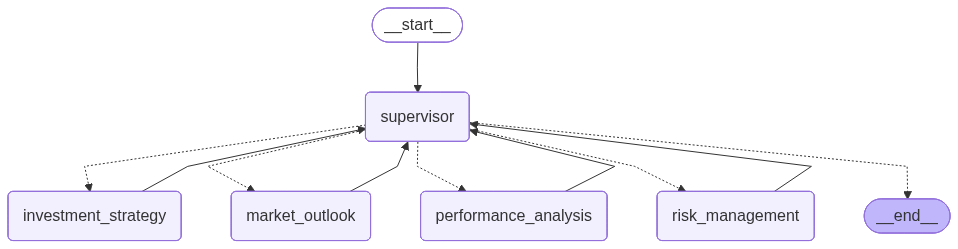

In [124]:
# Visualize the graph
try:
    from IPython.display import display, Image
    display(Image(supervisor_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(supervisor_graph.get_graph().draw_ascii())

In [95]:
# Test the supervisor system
print("Testing Supervisor Multi-Agent System")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What is Stone Ridge's view on the current market environment?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Supervisor Multi-Agent System
[Supervisor Claude Sonnet 4.5] Routing to: market_outlook
  Reason: This question asks about Stone Ridge's view on the current market environment, which directly relates to market trends, economic conditions, and the macro environment. This is clearly within the domain of the market_outlook specialist who handles questions about market trends and economic conditions.
[MARKET_OUTLOOK Agent] Processing request...
[MARKET_OUTLOOK Agent] Response complete.

Final Response:
[MARKET_OUTLOOK SPECIALIST]

Based on the search results, I can see that Stone Ridge's 2025 Investor Letter discusses their philosophy and approach, but the specific market outlook details aren't fully captured in these excerpts. However, I can share what I found:

**Stone Ridge's Approach to Markets:**

Stone Ridge emphasizes a **data-driven, Bayesian approach** to market analysis:
- They focus on "thinking deeply about what we know before we know"
- They maintain "open-mindedness t

In [96]:
# Test with an investment strategy question
print("Testing with investment strategy question")
print("=" * 50)

response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="How does Stone Ridge approach portfolio construction and asset allocation?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)

Testing with investment strategy question
[Supervisor Claude Sonnet 4.5] Routing to: investment_strategy
  Reason: This question is asking about portfolio construction and asset allocation, which are core investment strategy topics. The user wants to understand Stone Ridge's approach to building portfolios and allocating capital across different assets, which falls squarely within the investment_strategy specialist's domain.
[INVESTMENT_STRATEGY Agent] Processing request...
[INVESTMENT_STRATEGY Agent] Response complete.

Final Response:
[INVESTMENT_STRATEGY SPECIALIST]

Based on the available information from Stone Ridge's investor letters, here are the key aspects of their portfolio construction and asset allocation approach:

## Key Portfolio Construction Principles:

**1. Alignment & Principal Investing**
- Stone Ridge operates with significant principal capital invested alongside outside investors, creating strong alignment of interests
- The firm is increasingly its own largest in

## Task 4: Adding Tavily Search for Web Research

Sometimes the investment knowledge base doesn't have the latest information. Let's add **Tavily Search** to allow agents to search the web for current market data and financial news.

**Documentation:**
- [Tavily Search Tool](https://python.langchain.com/docs/integrations/tools/tavily_search/)
- [Tavily API Docs](https://docs.tavily.com/)

In [97]:
# Create a Tavily search tool (using updated langchain-tavily package)
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    max_results=3,
    topic="news"
)

print(f"Tavily search tool created: {tavily_search.name}")

Tavily search tool created: tavily_search


In [98]:
# Test Tavily search
search_results = tavily_search.invoke("latest Stone Ridge Asset Management investment performance 2025")
print("Tavily Search Results:")
print("-" * 50)

for result in search_results['results'][:2]:
    print(f"\nTitle: {result.get('title', 'N/A')}")
    print(f"URL: {result.get('url', 'N/A')}")
    print(f"Content: {result.get('content', 'N/A')[:200]}...")

Tavily Search Results:
--------------------------------------------------

Title: UK's Schroders pops 28% on Nuveen takeover that's set to create asset management giant - CNBC
URL: https://www.cnbc.com/2026/02/12/nuveen-schroders-asset-management-takeover.html
Content: # UK's Schroders pops 28% on Nuveen takeover that's set to create asset management giant. * Nuveen, the investment management wing of TIAA, is acquiring London-listed asset manager Schroders. * The $1...

Title: Exclusive | Vision Ridge Raises $2.4 Billion for Sustainable Asset Deals - The Wall Street Journal
URL: https://www.wsj.com/articles/vision-ridge-raises-2-4-billion-for-sustainable-asset-deals-0a94adc6?gaa_at=eafs&gaa_n=AWEtsqc9wkI2vfhoHdco0uFUdQy05YAAaF_J9sNedj1jRl5-mYYOKIl1Szqa&gaa_ts=698c6625&gaa_sig=HBskfrJBeLikITViUCWSgAVnDkhfILm-Ya798p8d8D9E4Y_erWfI0W8lzRNL_iLCUGytxHnz0TXDk9EXMdtgDQ%3D%3D
Content: Exclusive | Vision Ridge Raises $2.4 Billion for Sustainable Asset Deals - WSJ. S&P 500 Futures 6961.00 -0.01%.

In [99]:
# Create a research agent that can search both the investment knowledge base AND the web
@tool
def search_investment_kb(query: str) -> str:
    """Search the local investment knowledge base for information from the Stone Ridge investor letter.
    Use this first for questions about Stone Ridge's investment approach.
    """
    results = retriever.invoke(query)
    if not results:
        return "No information found in knowledge base."
    return "\n\n".join([f"[KB Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

@tool
def search_web_current(query: str) -> str:
    """Search the web for current market news, financial data, and recent investment information.
    Use this when you need the latest market updates or information not in the knowledge base.
    """
    response = tavily_search.invoke(query)
    if not response or not response.get('results'):
        return "No web results found."
    formatted = []
    for i, r in enumerate(response['results'][:3]):
        formatted.append(f"[Web Source {i+1}]: {r.get('content', 'N/A')}\nURL: {r.get('url', 'N/A')}")
    return "\n\n".join(formatted)

# Create a research agent with both tools (using create_agent)
research_agent = create_agent(
    model=specialist_llm,
    tools=[search_investment_kb, search_web_current],
    system_prompt="""You are an Investment Research Agent. You have access to both the Stone Ridge investor letter 
knowledge base and web search. Use the knowledge base for Stone Ridge-specific information and web search 
for current market data. Always cite your sources."""
)

print("Research agent with web search created (using create_agent)!")

Research agent with web search created (using create_agent)!


In [100]:
# Test the research agent
print("Testing Research Agent (KB + Web)")
print("=" * 50)

response = research_agent.invoke({
    "messages": [HumanMessage(content="What are the latest developments in alternative investments and risk management?")]
})

print("\nResearch Agent Response:")
print(response["messages"][-1].content)

Testing Research Agent (KB + Web)

Research Agent Response:
Based on my search, here are the latest developments in alternative investments and risk management:

## Current Market Developments

### **Private Credit Ecosystem Expansion**
According to recent industry reports, private credit is evolving beyond a single product into a comprehensive ecosystem. **Apollo** is leading this transformation with a model focused on:
- **Origination at scale** - manufacturing credit at volume
- **Permanent capital** - holding investments long-term
- **Distribution channels** - expanding into wealth and retirement allocations
- Growing concerns around **software-linked credit risk** tied to AI's potential disruption of traditional software revenue models

### **Insurer-Alternative Manager Partnerships**
There's a notable trend of strategic collaborations between insurers and alternative asset managers:
- **Liberty Mutual** partnered with **Ara Partners** for infrastructure and energy strategies, wit

---
## Question #1:

In the Supervisor pattern, the supervisor routes requests to specialist agents. What are the **advantages** and **disadvantages** of having agents loop back to the supervisor after responding, versus having them respond directly to the user? Consider this in the context of an investment advisory system where accuracy is critical.

##### Answer:
The advantage of having the specialist agent respond directly to the user is that it is a simple graph to build and maintain and the cost of executing a request is lower.

The primary advantage that I can think of is that the supervisor can verify the accuracy of the result before returning it to the user. However, I don't think that this should be the responsibility of the supervisor in THIS exmaple, because the supervisor is actually just a router and does not have access to external knowledge.

If we wanted to implement a verification process, I would suggest extending the graph so the output of the specialists go to a VERIFIER node (this could be the same specialist agent, but with a different user message and clean context) to check/verify the result for accuracy. The output of the verifier could be to END (output looks good!) or to feed it back into the specialist node in a loop, along with a user message explaining which inaccuracies were found and asking for corrections. This would then flow back through the verifier until the verifier was satified with the result. In this case, I would start each with a fresh context so that it acts with a "fresh set of eyes".


## Question #2:

We added Tavily web search alongside the investment knowledge base. In what scenarios would you want to **restrict** an agent to only use the knowledge base (no web search)? What are the trade-offs between freshness and reliability when providing investment information?

##### Answer:

We would want to **restrict** an agent to only use a knowledge base when accuracy is of utmost importance. For example, if we have an agent that answers regulatory and compliance questions, we want it to read from pre-screened regulatory documents and company-specific guidance, and not go off searching the internet for questionably accurate information.

The Tavily web search returned exactly ZERO relevant results about Stone Ridge because it is a private firm without a huge amount of publically available information. If the goal is to build an agent that specifically returns results about non-public information, than web search should be excluded from the tool set to avoid the agent pulling irrelevant and misleading information into the context window.

Using a search tool with relatively static information (for example, a vector database populated with curated Stone Ridge materials) removes a major source of variability: the external context the agent can draw on. That makes the system easier to evaluate and tune because you can rerun the same prompts and expect the agent to be operating over the same set of inputs, which improves repeatability and reliability. The downside is freshness—your answers are limited to what’s in the dataset and can lag new developments. By contrast, adding web search gives the agent access to vastly more information, but the retrieved results can shift from minute to minute (ranking changes, new pages appear, old pages disappear). That volatility makes behavior less predictable and can reduce reliability unless you add strong controls (source filtering, citations, retrieval auditing, and review/verification steps).

---
## Activity #1: Add a Custom Investment Specialist Agent

Add a new specialist agent to the supervisor system. Ideas:
- **Regulatory Agent**: Handles regulatory compliance and investment regulations
- **Macro Economic Agent**: Focuses on macroeconomic indicators and economic data
- **ESG Agent**: Addresses ESG criteria and sustainable investing

Requirements:
1. Create a specialized search tool for your agent's domain
2. Create the specialist agent with an appropriate system prompt
3. Add the agent to the supervisor graph
4. Update the routing logic
5. Test with relevant questions

In [101]:
# ADD ADDITIONAL KB FOR SEC DOC

private_fund_risk_documents = PyMuPDFLoader("data/Private Fund Risk Alert_0.pdf").load()
private_fund_risk_chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100).split_documents(documents)
print(f"Loaded and split into {len(private_fund_risk_chunks)} chunks")

qdrant_client_private_fund_risk = QdrantClient(":memory:")
qdrant_client_private_fund_risk.create_collection(
    collection_name="private_fund_risk",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE)
)

vector_store_private_fund_risk = QdrantVectorStore(
    client=qdrant_client_private_fund_risk,
    collection_name="private_fund_risk",
    embedding=embedding_model
)
vector_store_private_fund_risk.add_documents(private_fund_risk_chunks)

retriever_private_fund_risk = vector_store_private_fund_risk.as_retriever(search_kwargs={"k": 5})
print(f"Vector store ready with {len(chunks)} risk documents")


Loaded and split into 118 chunks
Vector store ready with 118 risk documents


In [102]:
# RECREATE SUPERVISOR NODE WITH NEW ROUTER OUTPUT FOR NEW SUB AGENT

class RouterOutput2(BaseModel):
    """The supervisor's routing decision."""
    next: Literal["market_outlook", "investment_strategy", "risk_management", "performance_analysis", "reg_compliance"]
    reasoning: str

routing_llm_2 = supervisor_llm.with_structured_output(RouterOutput2)

def supervisor_node_2(state: SupervisorState):
    """The supervisor decides which agent to route to."""
    # Get the user's question from the last human message
    user_question = ""
    for msg in reversed(state["messages"]):
        if isinstance(msg, HumanMessage):
            user_question = msg.content
            break
    
    # Get routing decision
    prompt_value = supervisor_prompt.invoke({"question": user_question})
    result = routing_llm_2.invoke(prompt_value)
    
    print(f"[Supervisor Claude Sonnet 4.5] Routing to: {result.next}")
    print(f"  Reason: {result.reasoning}")
    
    return {"next": result.next}


In [103]:
# Step 1: Create a specialized search tool
@tool
def search_regulatory_docs(query: str) -> str:
    """Search for SEC (OCIE/Division of Examinations) observations and common regulatory/compliance findings related to investment advisers, including exam themes, deficiencies, and best-practice expectations across areas such as conflicts of interest, fees and expenses, policies and procedures, MNPI controls, custody, disclosures, and governance. Use this for questions about adviser regulatory exams and compliance risks.
    """
    results = retriever_private_fund_risk.invoke(f"private fund adviser exam observations conflicts fees expenses policies procedures MNPI custody {query}")
    if not results:
        return "No private fund compliance observations found."
    return "\n\n".join([f"[Source {i+1}]: {doc.page_content}" for i, doc in enumerate(results)])

# Step 2: Create the specialist agent
reg_compliance_agent = create_agent(
    model=specialist_llm,
    tools=[search_regulatory_docs],
    system_prompt="You are a Private Fund Compliance Specialist. Help users understand regulatory requirements and compliance issues for investment advisers managing private funds. Always search the knowledge base before answering. Be concise and data-driven."
)
reg_compliance_node = create_agent_node(reg_compliance_agent, "reg_compliance")


In [104]:
# Step 3: Add to the supervisor graph (you may need to rebuild the graph)

# Create the graph
supervisor_workflow2 = StateGraph(SupervisorState)

# Add nodes
supervisor_workflow2.add_node("supervisor2", supervisor_node_2)
supervisor_workflow2.add_node("market_outlook", market_outlook_node)
supervisor_workflow2.add_node("investment_strategy", investment_strategy_node)
supervisor_workflow2.add_node("risk_management", risk_management_node)
supervisor_workflow2.add_node("performance_analysis", performance_analysis_node)
supervisor_workflow2.add_node("reg_compliance", reg_compliance_node)

# Add edges: START -> supervisor
supervisor_workflow2.add_edge(START, "supervisor2")

# Conditional routing from supervisor to specialists
supervisor_workflow2.add_conditional_edges(
    "supervisor2",
    route_to_agent,
    {
        "market_outlook": "market_outlook",
        "investment_strategy": "investment_strategy",
        "risk_management": "risk_management",
        "performance_analysis": "performance_analysis",
        "reg_compliance": "reg_compliance",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_workflow2.add_edge("market_outlook", END)
supervisor_workflow2.add_edge("investment_strategy", END)
supervisor_workflow2.add_edge("risk_management", END)
supervisor_workflow2.add_edge("performance_analysis", END)
supervisor_workflow2.add_edge("reg_compliance", END)

# Compile
supervisor_graph2 = supervisor_workflow2.compile()



In [105]:
# Step 4: Test your new agent
response = supervisor_graph2.invoke({
    "messages": [HumanMessage(content="What are common SEC examinations?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)


[Supervisor Claude Sonnet 4.5] Routing to: reg_compliance
  Reason: The question asks about SEC (Securities and Exchange Commission) examinations, which is a regulatory compliance topic. This falls under the domain of regulatory requirements, compliance procedures, and oversight activities conducted by financial regulators. The reg_compliance specialist is best equipped to handle questions about SEC examinations, regulatory processes, and compliance matters.
[REG_COMPLIANCE Agent] Processing request...
[REG_COMPLIANCE Agent] Response complete.

Final Response:
[REG_COMPLIANCE SPECIALIST]

I apologize—the knowledge base I have access to doesn't contain SEC examination guidance documents. However, I can provide you with general information about common SEC examinations for investment advisers:

**Common SEC Examination Areas for Investment Advisers:**

1. **Conflicts of Interest** – How advisers identify, disclose, and manage conflicts
2. **Fees and Expenses** – Reasonableness of advisor

---
#  🤝 Breakout Room #2
## Handoffs & Context Engineering

## Task 5: Agent Handoffs Pattern

The **Handoffs Pattern** allows agents to transfer control to each other based on the conversation context. Unlike the supervisor pattern, agents decide themselves when to hand off.

```
    User Question
         │
         ▼
    ┌──────────┐  "I need strategy help"  ┌──────────────┐
    │  Market  │ ────────────────────────► │  Investment  │
    │ Outlook  │                           │   Strategy   │
    │  Agent   │ ◄──────────────────────── │    Agent     │
    └──────────┘  "Back to market topics"  └──────────────┘
```

**Documentation:**
- [LangGraph Agent Handoffs](https://langchain-ai.github.io/langgraph/how-tos/agent-handoffs/)

In [106]:
# Create handoff tools that agents can use to transfer control
# Each tool returns a special HANDOFF string that the graph will detect

@tool
def transfer_to_market_outlook(reason: str) -> str:
    """Transfer to Market Outlook Specialist for market trends, economic conditions, and macro environment questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:market_outlook:{reason}"

@tool
def transfer_to_investment_strategy(reason: str) -> str:
    """Transfer to Investment Strategy Specialist for portfolio positioning, asset allocation, and investment approach questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:investment_strategy:{reason}"

@tool
def transfer_to_risk_management(reason: str) -> str:
    """Transfer to Risk Management Specialist for risk factors, tail risks, hedging, and diversification questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:risk_management:{reason}"

@tool
def transfer_to_performance_analysis(reason: str) -> str:
    """Transfer to Performance Analysis Specialist for returns, benchmarks, and performance metrics questions.
    
    Args:
        reason: Why you're transferring to this specialist
    """
    return f"HANDOFF:performance_analysis:{reason}"

print("Handoff tools created!")

Handoff tools created!


In [107]:
# Create agents with handoff capabilities (using create_agent)

market_outlook_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_market_outlook,
        transfer_to_investment_strategy,
        transfer_to_risk_management,
        transfer_to_performance_analysis
    ],
    system_prompt="""You are a Market Outlook Specialist. Answer questions about market trends, economic conditions, and the macro environment.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering market outlook questions."""
)

investment_strategy_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_investment_strategy,
        transfer_to_market_outlook,
        transfer_to_risk_management,
        transfer_to_performance_analysis
    ],
    system_prompt="""You are an Investment Strategy Specialist. Answer questions about portfolio positioning, asset allocation, and investment philosophy.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering investment strategy questions."""
)

risk_management_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_risk_info,
        transfer_to_market_outlook,
        transfer_to_investment_strategy,
        transfer_to_performance_analysis
    ],
    system_prompt="""You are a Risk Management Specialist. Answer questions about risk factors, tail risks, hedging, and diversification.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering risk management questions."""
)

performance_analysis_handoff_agent = create_agent(
    model=specialist_llm,
    tools=[
        search_performance_info,
        transfer_to_market_outlook,
        transfer_to_investment_strategy,
        transfer_to_risk_management
    ],
    system_prompt="""You are a Performance Analysis Specialist. Answer questions about investment returns, benchmarks, and performance metrics.
If the user's question is better suited for another specialist, use the appropriate transfer tool.
Always search the knowledge base before answering performance analysis questions."""
)

print("Handoff-enabled agents created (using create_agent)!")

Handoff-enabled agents created (using create_agent)!


In [108]:
# Build the handoff graph with transfer limit to prevent infinite loops

class HandoffState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    current_agent: str
    transfer_count: int  # Track transfers to prevent infinite loops

MAX_TRANSFERS = 2  # Maximum number of handoffs allowed

def parse_handoff(content: str) -> tuple[bool, str, str]:
    """Parse a handoff from agent response."""
    if "HANDOFF:" in content:
        parts = content.split("HANDOFF:")[1].split(":")
        return True, parts[0], parts[1] if len(parts) > 1 else ""
    return False, "", ""

def create_handoff_node(agent, name: str):
    """Create a node that can handle handoffs."""
    def node(state: HandoffState):
        print(f"[{name.upper()} Agent] Processing...")
        result = agent.invoke({"messages": state["messages"]})
        last_message = result["messages"][-1]
        
        # Check for handoff in tool messages (only if under transfer limit)
        if state["transfer_count"] < MAX_TRANSFERS:
            for msg in result["messages"]:
                if hasattr(msg, 'content') and "HANDOFF:" in str(msg.content):
                    is_handoff, target, reason = parse_handoff(str(msg.content))
                    if is_handoff:
                        print(f"[{name.upper()}] Handing off to {target}: {reason}")
                        return {
                            "messages": [AIMessage(content=f"[{name}] Transferring to {target} specialist: {reason}")],
                            "current_agent": target,
                            "transfer_count": state["transfer_count"] + 1
                        }
        
        # No handoff (or limit reached), return final response
        response = AIMessage(
            content=f"[{name.upper()} SPECIALIST]\n\n{last_message.content}",
            name=name
        )
        print(f"[{name.upper()} Agent] Response complete.")
        return {"messages": [response], "current_agent": "done", "transfer_count": state["transfer_count"]}
    
    return node

# Create nodes
market_outlook_handoff_node = create_handoff_node(market_outlook_handoff_agent, "market_outlook")
investment_strategy_handoff_node = create_handoff_node(investment_strategy_handoff_agent, "investment_strategy")
risk_management_handoff_node = create_handoff_node(risk_management_handoff_agent, "risk_management")
performance_analysis_handoff_node = create_handoff_node(performance_analysis_handoff_agent, "performance_analysis")

print("Handoff nodes created!")

Handoff nodes created!


In [109]:
# Build the handoff graph with initial routing (using Claude Sonnet 4.5)

def entry_router(state: HandoffState):
    """Initial routing based on the user's question (using Claude Sonnet 4.5)."""
    user_question = state['messages'][-1].content
    
    router_prompt = f"""Based on this question, which specialist should handle it?
Options: market_outlook, investment_strategy, risk_management, performance_analysis

Question: {user_question}

Respond with just the specialist name (one word or underscore-separated)."""
    
    response = supervisor_llm.invoke(router_prompt)
    agent = response.content.strip().lower()
    
    # Validate
    if agent not in ["market_outlook", "investment_strategy", "risk_management", "performance_analysis"]:
        agent = "market_outlook"  # Default to market outlook for general questions
    
    print(f"[Router Claude Sonnet 4.5] Initial routing to: {agent}")
    return {"current_agent": agent, "transfer_count": 0}

def route_by_current_agent(state: HandoffState) -> str:
    """Route based on current_agent field."""
    return state["current_agent"]

# Build graph
handoff_workflow = StateGraph(HandoffState)

# Add nodes
handoff_workflow.add_node("router", entry_router)
handoff_workflow.add_node("market_outlook", market_outlook_handoff_node)
handoff_workflow.add_node("investment_strategy", investment_strategy_handoff_node)
handoff_workflow.add_node("risk_management", risk_management_handoff_node)
handoff_workflow.add_node("performance_analysis", performance_analysis_handoff_node)

# Entry point
handoff_workflow.add_edge(START, "router")

# Router to agents
handoff_workflow.add_conditional_edges(
    "router",
    route_by_current_agent,
    {
        "market_outlook": "market_outlook",
        "investment_strategy": "investment_strategy",
        "risk_management": "risk_management",
        "performance_analysis": "performance_analysis"
    }
)

# Agents can handoff to each other or end
for agent_name in ["market_outlook", "investment_strategy", "risk_management", "performance_analysis"]:
    handoff_workflow.add_conditional_edges(
        agent_name,
        route_by_current_agent,
        {
            "market_outlook": "market_outlook",
            "investment_strategy": "investment_strategy",
            "risk_management": "risk_management",
            "performance_analysis": "performance_analysis",
            "done": END
        }
    )

# Compile
handoff_graph = handoff_workflow.compile()

print("Handoff multi-agent system built!")

Handoff multi-agent system built!


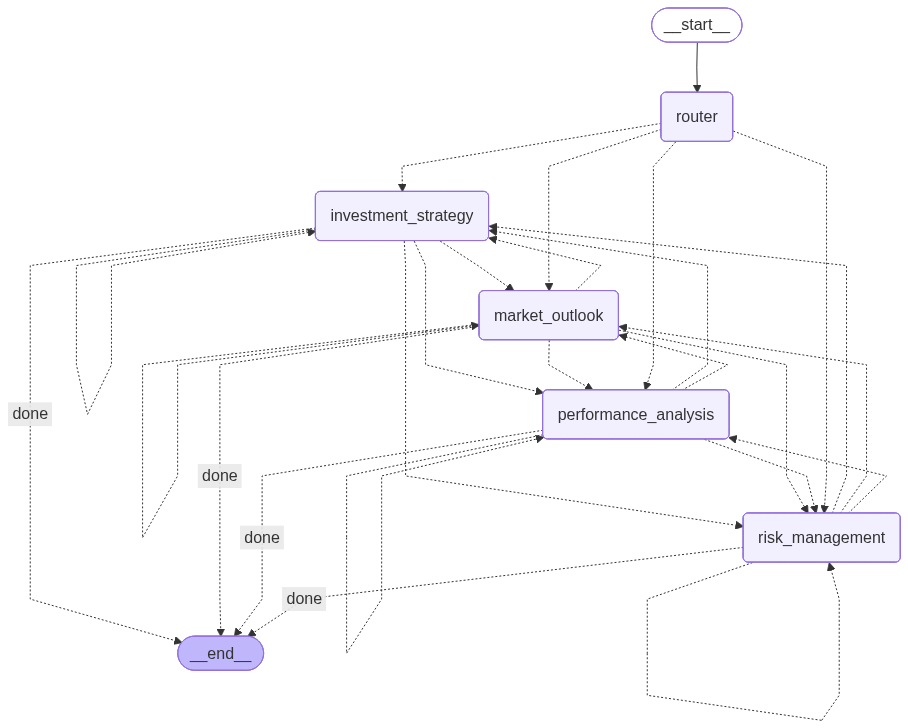

In [110]:
# Visualize the handoff graph
try:
    from IPython.display import display, Image
    display(Image(handoff_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(handoff_graph.get_graph().draw_ascii())

In [111]:
# Test the handoff system
print("Testing Handoff System")
print("=" * 50)

response = handoff_graph.invoke({
    "messages": [HumanMessage(content="I'm concerned about market volatility and want to understand the risk in my portfolio. What should I do?")],
    "current_agent": "",
    "transfer_count": 0
})

print("\n" + "=" * 50)
print("FINAL RESPONSE:")
print("=" * 50)
print(response["messages"][-1].content)

Testing Handoff System
[Router Claude Sonnet 4.5] Initial routing to: risk_management
[RISK_MANAGEMENT Agent] Processing...
[RISK_MANAGEMENT Agent] Response complete.

FINAL RESPONSE:
[RISK_MANAGEMENT SPECIALIST]

Based on the search results and my expertise as a Risk Management Specialist, here's what I recommend to address your concerns about market volatility:

## Key Steps to Understand and Manage Portfolio Risk:

**1. Assess Your Current Risk Exposure**
   - Identify concentration risks in your portfolio
   - Understand which positions are most sensitive to market volatility
   - Evaluate correlation patterns between your holdings

**2. Implement Diversification**
   - Diversify across asset classes, sectors, and geographies
   - Avoid concentration in correlated assets
   - Consider alternative investments that may behave differently in volatile markets

**3. Consider Hedging Strategies**
   - Evaluate tail risk hedging to protect against extreme market moves
   - Use strategic h

## Task 6: Building an Investment Agent Team

Now let's combine what we've learned to build a complete investment team that can:
1. Handle complex multi-domain investment questions
2. Search both the knowledge base and the web
3. Maintain conversation context
4. Provide comprehensive investment advisory guidance

In [112]:
# Create a unified investment team with memory
from langgraph.checkpoint.memory import MemorySaver

# Add memory to the supervisor graph
memory = MemorySaver()

supervisor_with_memory = supervisor_workflow.compile(checkpointer=memory)

print("Supervisor with memory created!")

Supervisor with memory created!


In [115]:
# Test multi-turn conversation
thread_id = "investment-session-1"
config = {"configurable": {"thread_id": thread_id}}

print("Multi-turn Conversation Test")
print("=" * 50)

# First question
response1 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="What is Stone Ridge's investment philosophy?")]},
    config=config
)
print("\n[Turn 1 Response]:")
print(response1["messages"][-1].content[:500])

Multi-turn Conversation Test
[Supervisor Claude Sonnet 4.5] Routing to: investment_strategy
  Reason: The question asks about Stone Ridge's investment philosophy, which relates to their overall investment approach and how they think about constructing portfolios. This is a core investment strategy question that deals with the firm's fundamental beliefs and methodology for investing, making it best suited for the investment_strategy specialist.
[INVESTMENT_STRATEGY Agent] Processing request...
[INVESTMENT_STRATEGY Agent] Response complete.

[Turn 1 Response]:
[INVESTMENT_STRATEGY SPECIALIST]

## Stone Ridge's Investment Philosophy

Based on their investor letters, here are the core pillars:

### **1. Principal-Investor Alignment**
- Stone Ridge operates as **principals, not agents**, with significant capital at stake alongside outside investors
- This creates exceptional alignment that investors recognize as distinctly different
- The scale of profits as principals creates a "wonderfull

In [116]:
# Follow-up question (should remember context)
response2 = supervisor_with_memory.invoke(
    {"messages": [HumanMessage(content="How do they manage risk in their portfolio?")]},
    config=config
)
print("\n[Turn 2 Response]:")
print(response2["messages"][-1].content[:500])

[Supervisor Claude Sonnet 4.5] Routing to: risk_management
  Reason: The question explicitly asks about how risk is managed in a portfolio. This directly falls under the risk_management specialist's domain, which handles risk factors, tail risks, hedging, diversification, and risk management strategies.
[RISK_MANAGEMENT Agent] Processing request...
[RISK_MANAGEMENT Agent] Response complete.

[Turn 2 Response]:
[RISK_MANAGEMENT SPECIALIST]

[RISK_MANAGEMENT SPECIALIST]

## Stone Ridge's Risk Management Approach

Based on their investor letters, Stone Ridge employs several key risk management strategies:

### **1. Selective Risk Transfer & Partnership Alignment**
- **Prospective Quota Shares**: Stone Ridge uses aligned, partnership-based trades where they share risk **pro rata** with leading reinsurers
- This approach taps into reinsurers' expertise in **Bayesian updating and cycle management** across m


## Task 7: Context Engineering & Optimization

As conversations grow, we need to manage context carefully. Key principles:

1. **Context Window as Prime Real Estate**: Only include what's necessary
2. **Summarization**: Compress long conversations
3. **Selective Retrieval**: Don't retrieve everything, just what's relevant
4. **Context Rot**: More tokens doesn't mean better performance

In [120]:
# Implement a context summarization function (using Claude Haiku for cost efficiency)
# This helps manage context length in multi-turn investment advisory conversations

def summarize_conversation(messages: list[BaseMessage], max_messages: int = 6) -> list[BaseMessage]:
    """Summarize older messages to manage context length."""
    if len(messages) <= max_messages:
        return messages
    
    # Keep the first message (original question) and last few messages
    old_messages = messages[1:-max_messages+1]
    recent_messages = messages[-max_messages+1:]
    
    # Summarize old messages
    summary_prompt = f"""Summarize this conversation history in 2-3 sentences, 
capturing the key topics discussed and any important decisions made:

{chr(10).join([f'{m.type}: {m.content[:200]}' for m in old_messages])}"""
    
    summary = specialist_llm.invoke(summary_prompt)
    
    # Return: first message + summary + recent messages
    return [
        messages[0],
        SystemMessage(content=f"[Previous conversation summary: {summary.content}]"),
        *recent_messages
    ]

print("Context summarization function created!")

Context summarization function created!


In [121]:
# Demonstrate context optimization
sample_messages = [
    HumanMessage(content="I want to understand Stone Ridge's investment approach"),
    AIMessage(content="Great question! Let's start with their philosophy."),
    HumanMessage(content="What about their risk management?"),
    AIMessage(content="Stone Ridge focuses on tail risk hedging..."),
    HumanMessage(content="How have they performed?"),
    AIMessage(content="Their performance has been..."),
    HumanMessage(content="What about portfolio construction?"),
    AIMessage(content="For portfolio construction..."),
    HumanMessage(content="What's their outlook for the current market?"),
]

print(f"Original messages: {len(sample_messages)}")

optimized = summarize_conversation(sample_messages, max_messages=4)
print(f"Optimized messages: {len(optimized)}")
print("\nOptimized conversation:")
for msg in optimized:
    print(f"  [{msg.type}]: {msg.content[:100]}...")

Original messages: 9
Optimized messages: 5

Optimized conversation:
  [human]: I want to understand Stone Ridge's investment approach...
  [system]: [Previous conversation summary: # Conversation Summary

The conversation discusses Stone Ridge's inv...
  [human]: What about portfolio construction?...
  [ai]: For portfolio construction......
  [human]: What's their outlook for the current market?...


---
## Question #3:

Compare the **Supervisor pattern** and the **Handoffs pattern** we implemented. What are the key differences in how routing decisions are made? When would you choose one pattern over the other for an investment advisory system?

##### Answer:
The key difference is who makes routing decisions and when. In the Supervisor pattern, a smart model (Claude Sonnet) analyzes the request upfront and routes to a single specialist, which then returns the final answer. The flow is deterministic: User --> Supervisor --> Specialist --> END.

In the Handoffs pattern, the supervisor still makes an initial routing decision, but specialists can re-route by calling handoff tools. The graph detects these tool calls after the agent completes its turn, discards the agent's response, and routes to the next specialist. This continues until a specialist answers without handing off, or until the transfer limit is reached.

For this specific implementation, the handoffs pattern should not be used. The smart model (Claude Sonnet) already made the routing decision - it makes no sense to let the cheaper specialist models (Claude Haiku) second-guess that decision. If the specialist doesn't have the appropriate information, it should return "I don't know" rather than re-route.

This handoff implementation seems flawed for this use case: when a specialist hands off, its response is discarded and replaced with a generic "Transferring to X" message, so information is lost. I could see the handoffs pattern being more useful is there was some shared state tracking progress of tasks and the order of task execution was not known. An agent could do work, mark a task as complete, and hand off to an supervisor agent that could determine the next step.


## Question #4:

We discussed "Context Rot" - the idea that longer context doesn't always mean better performance. How does this principle apply to multi-agent investment advisory systems? What strategies can you use to manage context effectively when dealing with complex financial information?

##### Answer:

Multi-agent systems can either alleviate or exacerbate context rot depending on how they are designed. For example, in the exercise above, the handoff includes the full message history of the workflow (at least, I think that's how it works). So, despite "new agents" being run, the full accumulated context is present in the shared memory that all of the agents are using. This means that accumulated and potentially irrelevant information is being accumulated at each hop. If, instead, each agent tracked its own messages, then each hand-off would start with a clear context, alleviating context rot. The challenge with that approach is that the agent handing off the request must be sure to include all of the relevant information that the next agent needs, which is not an easy problem.

Strategies that could be used to manage context effectively:
- Token limit compaction: periodically summarize all messages, including conversation and tool results, thus far. A reasonable approach would be to keep the first message, keep the last 10 messages, and summarize the rest. The compaction should occur at token boundaries where performance degradation begins for a given model. How many messages to keep could also be tuned for the use case via trial and error.
- In-flight compaction: compact as you go. Understand the workflow and optimzie it. For example, if a tool call fails and then succeeds on a subsequent attempt, compact the failed tool call context to a single message "tool failed" instead of including large stack traces that are irrelevant.
- Write tools that spare your context. The tools that are implemented should be encouraged to spare the context. Claude Code does this, for example, with a Read tool that discourages or disallows reading huge amounts all at once. Other options could be to write API responses to a file and then allow the agent to grep them, rather than dropping the entire payload directly into the context window.
- Optimize the system prompt. Eliminate redundant data. Use only clear, concise, direct wording.


---
## Activity #2: Implement Hierarchical Teams

Build a **Hierarchical Agent System** where a top-level supervisor manages multiple team supervisors, each with their own specialist agents.

### Requirements:

1. Create an **Investment Director** (top-level supervisor using Claude Sonnet 4.5) that:
   - Receives user questions and determines which team should handle it
   - Routes to either the "Markets Team" or "Strategy Team"
   - Aggregates final responses from teams

2. Create two **Team Supervisors**:
   - **Markets Team Lead**: Manages Market Outlook Agent and Performance Analysis Agent
   - **Strategy Team Lead**: Manages Investment Strategy Agent and Risk Management Agent

3. Implement the hierarchical routing:
   - User question -> Investment Director -> Team Lead -> Specialist Agent -> Response

4. Test with questions that require different teams:
   - "What is Stone Ridge's view on the current market environment?" (Markets team)
   - "How does Stone Ridge manage tail risk in its portfolios?" (Strategy team)

### Architecture:
```
                    ┌──────────────────────┐
                    │ Investment Director  │
                    │  (Claude Sonnet 4.5) │
                    └──────────┬───────────┘
                               │
              ┌────────────────┴────────────────┐
              │                                 │
              ▼                                 ▼
   ┌─────────────────────┐          ┌─────────────────────┐
   │   Markets Team      │          │   Strategy Team     │
   │     Lead            │          │     Lead            │
   └──────────┬──────────┘          └──────────┬──────────┘
              │                                 │
       ┌──────┴──────┐                   ┌──────┴──────┐
       │             │                   │             │
       ▼             ▼                   ▼             ▼
  ┌──────────┐ ┌────────────┐    ┌────────────┐ ┌──────────┐
  │ Market   │ │Performance │    │ Investment │ │   Risk   │
  │ Outlook  │ │ Analysis   │    │  Strategy  │ │Management│
  │  Agent   │ │   Agent    │    │   Agent    │ │  Agent   │
  └──────────┘ └────────────┘    └────────────┘ └──────────┘
```

**Documentation:**
- [LangGraph Hierarchical Teams](https://langchain-ai.github.io/langgraph/tutorials/multi_agent/hierarchical_agent_teams/)

In [128]:
###################################
# Prompts
###################################

# Markets Team Lead
markets_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Markets Team Lead.
Your team has two specialists:
- market_outlook: Handles market trends, economic conditions, and macro environment
- performance_analysis: Handles returns, benchmarks, and performance metrics

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

# Strategy Team Lead  
strategy_team_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Strategy Team Lead.
Your team has two specialists:
- investment_strategy: Handles portfolio positioning, asset allocation, and investment philosophy
- risk_management: Handles risk factors, tail risks, hedging, and diversification

Route to the most appropriate specialist for the user's question."""),
    ("human", "Question: {question}")
])

director_prompt = ChatPromptTemplate.from_messages([
    ("system", """You are the Investment Director overseeing two teams:
- markets: Markets Team (market outlook, performance analysis)
- strategy: Strategy Team (investment strategy, risk management)

Route to the appropriate team based on the user's question."""),
    ("human", "Question: {question}")
])

In [ ]:
###################################
# Generic functions to reduce boilerplate for creating a supervisor
###################################

def create_router_output(options: list[str]) -> type[BaseModel]:
    """Create a RouterOutput class with the given routing options."""
    options_literal = Literal[tuple(options)]  # type: ignore

    class RouterOutput(BaseModel):
        """The supervisor's routing decision."""
        next: options_literal  # type: ignore
        reasoning: str

    return RouterOutput

def create_routing_llm(options: list[str]):
    """Create an LLM bound to structured output for the given routing options."""
    router_output = create_router_output(options)
    return supervisor_llm.with_structured_output(router_output)

def create_supervisor_node(options: list[str], prompt: ChatPromptTemplate):
    """Create a supervisor node that routes to the given options."""
    routing_llm = create_routing_llm(options)

    def supervisor_node(state: SupervisorState):
        """The supervisor decides which agent to route to."""
        user_question = ""
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                user_question = msg.content
                break

        prompt_value = prompt.invoke({"question": user_question})
        result = routing_llm.invoke(prompt_value)

        print(f"[Supervisor] Routing to: {result.next}")
        print(f"  Reason: {result.reasoning}")

        return {"next": result.next}

    return supervisor_node


In [132]:
###################################
# Create supervisor nodes using the generic function
###################################

director_node = create_supervisor_node(
    ["markets", "strategy"], 
    director_prompt
)
strategy_lead_node = create_supervisor_node(
    ["investment_strategy", "risk_management"], 
    strategy_team_prompt
)
markets_lead_node = create_supervisor_node(
    ["market_outlook", "performance_analysis"], 
    markets_team_prompt
)

In [133]:
###################################
# Wire up the graph
###################################
# Create the graph
supervisor_workflow = StateGraph(SupervisorState)

# Add nodes
supervisor_workflow.add_node("director", director_node)
supervisor_workflow.add_node("strategy", strategy_lead_node)
supervisor_workflow.add_node("markets", markets_lead_node)
supervisor_workflow.add_node("market_outlook", market_outlook_node)
supervisor_workflow.add_node("investment_strategy", investment_strategy_node)
supervisor_workflow.add_node("risk_management", risk_management_node)
supervisor_workflow.add_node("performance_analysis", performance_analysis_node)

# Add edges: START -> supervisor
supervisor_workflow.add_edge(START, "director")

# Conditional routing from director to managers
supervisor_workflow.add_conditional_edges(
    "director",
    route_to_agent,
    {
        "strategy": "strategy",
        "markets": "markets"
    }
)

# Conditional routing from director to managers
supervisor_workflow.add_conditional_edges(
    "strategy",
    route_to_agent,
    {
        "investment_strategy": "investment_strategy",
        "risk_management": "risk_management",
    }
)

# Conditional routing from director to managers
supervisor_workflow.add_conditional_edges(
    "markets",
    route_to_agent,
    {
        "market_outlook": "market_outlook",
        "performance_analysis": "performance_analysis",
    }
)

# KEY FIX: Each specialist goes directly to END (no looping!)
supervisor_workflow.add_edge("market_outlook", END)
supervisor_workflow.add_edge("investment_strategy", END)
supervisor_workflow.add_edge("risk_management", END)
supervisor_workflow.add_edge("performance_analysis", END)

# Compile
supervisor_graph = supervisor_workflow.compile()

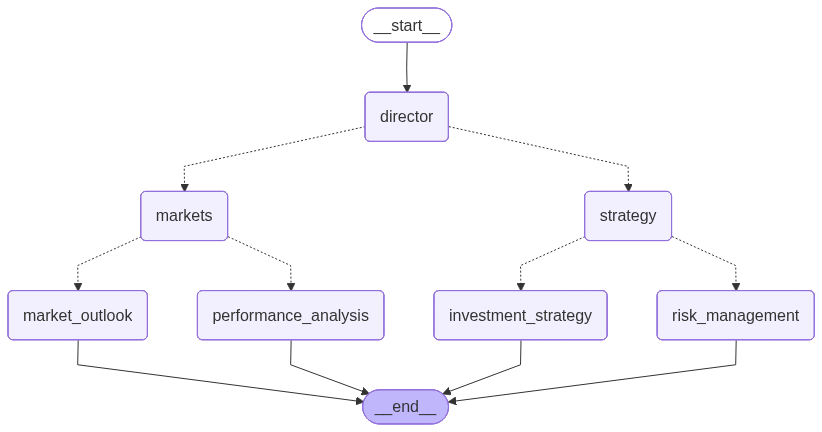

In [ ]:
###################################
# Visualize the graph
###################################
try:
    from IPython.display import display, Image
    display(Image(supervisor_graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Could not display graph: {e}")
    print("\nGraph structure:")
    print(supervisor_graph.get_graph().draw_ascii())

In [135]:
###################################
# Run it
###################################
response = supervisor_graph.invoke({
    "messages": [HumanMessage(content="What is Stone Ridge's view on the current market environment?")]
})

print("\nFinal Response:")
print("=" * 50)
print(response["messages"][-1].content)


[Supervisor] Routing to: markets
  Reason: The question asks about Stone Ridge's view on the current market environment, which falls under market outlook and analysis. This is clearly within the scope of the Markets Team who handles market outlook and performance analysis.
[Supervisor] Routing to: market_outlook
  Reason: The question asks about Stone Ridge's view on the current market environment, which relates to market trends, economic conditions, and the macro environment. This falls squarely within the market_outlook specialist's domain rather than performance_analysis which focuses on returns and metrics.
[MARKET_OUTLOOK Agent] Processing request...
[MARKET_OUTLOOK Agent] Response complete.

Final Response:
[MARKET_OUTLOOK SPECIALIST]

Based on the search results, I can see that Stone Ridge's 2025 Investor Letter discusses their philosophy and approach, but the specific market outlook details aren't fully captured in these excerpts. However, I can share what I found:

**Stone Rid

---
## Summary

In this module, we:

1. **Understood Multi-Agent Systems**: When to use them and key patterns
2. **Built a Supervisor Pattern**: Central orchestrator routing to investment specialists
3. **Implemented Agent Handoffs**: Investment agents transferring control to each other
4. **Added Web Search**: Tavily for current market data alongside the Stone Ridge knowledge base
5. **Applied Context Engineering**: Managing context for optimal performance with financial information

### Key Takeaways:

- **Don't over-engineer**: Only add agents when you truly need specialization
- **Context is key**: Manage your context window carefully, especially with dense financial data
- **Patterns matter**: Choose the right pattern for your investment advisory use case

**Further Reading:**
- [Building Effective Agents (Anthropic)](https://www.anthropic.com/engineering/building-effective-agents)
- [Don't Build Multi-Agents (Cognition)](https://cognition.ai/blog/dont-build-multi-agents)
- [12-Factor Agents](https://github.com/humanlayer/12-factor-agents)